# Project 3 - Text classification with Naive Bayes

### Nicholas Colan | UB: 5014 2568
### April 13, 2023 | MTH 448

In [5]:
import pandas as pd
from collections import Counter
import numpy as np
import string
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

# Introduction

Bayesian inference is a statistical method used to predict outcomes about prior unknown events. This method uses Thomas Bayes' theorem, which uses prior knowledge about related events to make a prediction about the outcome of future events. In this project we will look at Bayes' Theorem, and apply it to different datasets to make predictions about the nature of the data.

We will first start by looking at movie reviews with both positive and negative sentiments. There are over `25,000` reviews contained in this dataset, with a wide range of genres and timeframes. We start by using `80%` of this movie reviews dataset in order to build up our data in which to train our model on. We will then use the remaining `20%` of the data for testing, and observe how well our model can predict whether the movie review is of a positive or negative sentiment. Our model will make use of word counts for both the positive and negative reviews, and will base its prediction of a review off of how common those words appear in both the positive and negative reviews.

We will also explore how our model's prediction success rate changes based upon varying sizes in our training set, as well as how it performs when we remove 'stop words' from our training data. Stop words are commonly used words such as 'the','and','to',etc., which are frequently used but do not carry much meaning. Removing these stopwords should help to fine tune our model, as it will rely on more unique words found throughout positive and negative reviews to base its prediction. After this, we will explore reviews for different movies found on 'Rotten Tomatoes' website, a popular movie review site. We will use our model to analyze these reviews and see how well it can predict whether the review was positive or negative.

We will then analyze a dataset that contains past debates for electoral office positions in the United States, specifically two debates between Donald Trump and Hillary Clinton during the run up to the 2016 United States presidental election. We will analyze what the most commonly spoken words by the two candidates were, and try to predict who the speaker is on future quotes spoken by the two candidates during debates.

## Movie Reviews

We first will need to open our `movie_reviews.zip` file and put all the data into a pandas dataframe so that the data can be easily accessible. We can see that this is a large dataset.

In [6]:
movies = pd.read_csv('movie_reviews.zip')
len(movies)

25000

Now we want to use 80% of this data in order to form our training set, and the other 20% will be used as a test set. We will split this up using `sklearn's` method `train_test_split()`.

In [7]:
train_df, test_df = train_test_split(movies, train_size=0.8, random_state=1)

We will use `80%` of this dataset for training `(20,000 reviews)`, and the other `5,000` for testing.

In [8]:
len(train_df)

20000

Now in orer to classify these texts, we need to create a dataframe that will count the ocurence of each word that appears in both the positive and negative reviews. This string is taken from the internet, and therefore is formatted in a way for the browser to correctly parse it. This includes having linebreak characters. We also 
want to remove any characters that are not words, such as `.`,`?`,`()`, etc. Lastly, we will want to convert all of the letters in the review string to lowercase for consistent analysis.

The function `clean_string()` will take in a string as a parameter, and will 'clean' it so that we can properly 
parse through the data.

In [9]:
def clean_string(dirty):
    replacements = [('<br />',''),('\\',''),('.',' '),('!',''),('?',''),('(',''),(')',''),('-',' '),('"',''),(',','')]
    dirty = dirty.lower() # Make all of the words lowercase for consistent results
    for char, replace in replacements:
        if char in dirty:
            dirty = dirty.replace(char, replace) # If any unwanted symbols appear replace them with blank space
    return dirty

The function `count_word_occurences()` takes a `pandas dataframe` as an input, and counts the word occurences for both the positive and negative move reviews.

In [3]:
def count_word_occurences(movie_dataframe):
    # Create empty Counters for positive and negative reviews
    positive_counter = Counter()
    negative_counter = Counter()

    # Iterate through each row of the movies dataframe
    for index, row in movie_dataframe.iterrows():
        # Clean the review string
        clean_review = clean_string(row['review'])
        words = clean_review.split()
        # Add words to the appropriate counter based on the sentiment
        if row['sentiment'] == 'positive':
            positive_counter.update(words)
        elif row['sentiment'] == 'negative':
            negative_counter.update(words)
            
    word_counts = pd.DataFrame(columns=['negative', 'positive'])

    # Iterate through each word in the positive and negative counters
    for word in set(list(positive_counter.keys()) + list(negative_counter.keys())):
        # Add a new row to the dataframe with the count for this word
        word_counts.loc[word] = [negative_counter[word], positive_counter[word]]

    # Fill any missing values with 0
    word_counts = word_counts.fillna(0)
    
    word_counts_sorted = word_counts.sort_values(by=['positive', 'negative'], ascending=False)
    
    return word_counts_sorted

We are generating word counts for `20,000` reviews, all of which contain many words. This takes a long time to generate, and the results have been pre-run and stored in a file named `movie_review_training_data.csv` for quick access.

In [10]:
#movie_word_occurences = count_word_occurences(train_df)
#movie_word_occurences.to_csv('movie_review_training_data.csv')

In [11]:
training_data_with_stop_words = pd.read_csv('movie_review_training_data.csv')
training_data_with_stop_words = training_data_with_stop_words.set_index('Unnamed: 0').rename_axis('', axis='index')

In [12]:
training_data_with_stop_words

negative  positive
                                     
the                  130527    139254
and                   59439     72050
a                     63043     67277
of                    55294     62110
to                    55226     53663
...                     ...       ...
'fatal                    1         0
hussars                   1         0
misrepresentative         1         0
muto                      1         0
lighti                    1         0

[96963 rows x 2 columns]

## Testing With Stop Words

The function `rev_probs()` takes a string (the movie review), and the training data as a parameter and will return the logarithm of probabilities that will help to determine wether or not the review is positive or negative. This function uses `Laplacian Smoothing` to prevent any words with a count of `zero` from causing a zero probability being computed. We are adding `1` to every word count to achieve this.

In [13]:
def rev_probs(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['positive','negative']].add(1)
    
    # Compute the prior probabilities of the positive and negative classes using the training data
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(2)
    prod[0] = laplace_training_data['negative'].sum()/(tot)
    prod[0] = laplace_training_data['positive'].sum()/(tot)
    
    # Compute 'log' probabilites, add them to prod array:
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['positive','negative'][np.argmax(prod)]) 

 Many of these test reviews are full of spelling errors and therefore will not appear in our training set, creating errors when we try to analyze them. To fix that we will remove any word from the string that does not appear in our training data.

In [14]:
valid_words_with_stop_words = list(training_data_with_stop_words.index)

The function `remove_non_valid_words()` takes a string as its input, cleans the string of any unwanted symbols, and then removes all words that dont appear in the training dataset. 

In [15]:
def remove_non_valid_words(review_string,valid_words):
    review = clean_string(review_string).split()
    for word in review:
        if word not in valid_words:
            review = [x for x in review if x != word]
    review1 = ' '.join(review)
    return review1

The function `test_classifier()` takes 2 inputs:
* The testing data 
* The training data

and outputs the results of the classification of the movie review data.

In [16]:
def test_classifier(test_set,training_data,valid_words):
    results_list = []
    correct = 0
    testSize = len(test_df)
    
    for i in range(len(test_df)):
        # Retrive actual sentiment
        actual = test_df.iloc[i]['sentiment']
        # Remove non-valid words, then usse cleaned string and training data to make prediction
        prediction = rev_probs(remove_non_valid_words(test_df.iloc[i]['review'],valid_words),training_data)
        if actual == prediction[1]:
            correct += 1
        results_list.append((actual,prediction))
    # Add percentage correct to results
    results_list.append('{:} / {:} = {:}%'.format(correct,testSize,(correct/testSize)*100))
    
    return results_list

These results took a long time to generate. For quick access I have stored the result of `test_classifier()` in a file named `movie_review_testing_results_with_stop_words.txt`.

In [17]:
#results_list_with_stop_words = test_classifier(test_df,training_data_with_stop_words,valid_words_with_stop_words)

In [18]:
#with open('movie_review_testing_results_with_stop_words.txt','w') as f:
#    for item in results_list_with_stop_words:
#        f.write(str(item))
#        f.write('\n')

In [19]:
with open('movie_review_testing_results_with_stop_words.txt','r') as f:
    results_with_stop_words = f.read().splitlines()
    
results_with_stop_words[-1]

'4232 / 5000 = 84.64%'

We can see that our model can correctly predict the sentiment of a movie review in the `movie_reviews` data `84.6%` of the time. This is an accurate predictor, however let's see what happens when we remove stop words from our training data. This should increase the success rate of our predictor.

## How Does the Classification Accuracy Change When We Remove Stop Words?

In [20]:
with open ('stopwords.txt') as f:
    stops = f.read()

stop_words = stops.split(',')

In [21]:
training_data_no_stop_words = pd.read_csv('movie_review_training_data.csv')
training_data_no_stop_words = training_data_no_stop_words.set_index('Unnamed: 0').rename_axis('', axis='index')
training_data_no_stop_words = training_data_no_stop_words.drop(stop_words,errors='ignore')

In [22]:
valid_words_no_stop_words = list(training_data_no_stop_words.index)

## Testing Without Stop Words

Again, these results took a long time to generate. For quick access I have stored the result of `test_classifier()` without stop words in a file named `movie_review_testing_results_no_stop_words.txt`.

In [23]:
#results_list_no_stop_words = test_classifier(test_df,training_data_no_stop_words,valid_words_no_stop_words)

In [24]:
#with open('movie_review_testing_results_no_stop_words.txt','w') as f:
#    for item in results_list_no_stop_words:
#        f.write(str(item))
#        f.write('\n')

In [25]:
with open('movie_review_testing_results_no_stop_words.txt','r') as f:
    results_no_stop_words = f.read().splitlines()
    
results_no_stop_words[-1]

'4306 / 5000 = 86.11999999999999%'

We can see that removing the stop words increased the success rate of our predictor, going from `84.64%` to `86.2%`. Our model was able to correctly classify an additional `74` movie reviews when we removed the stop words from our training data.

## How Does Classification Accuracy Change With A Differing Training Set Size?

We will now explore how much classification accuracy of movie sentiments will be affected when we vary the size of the training set. We will remove stop words when analyzing this. The function below, `generate_classification_accuracy()`, will iteratively change the size of the training set to be used by `sklearn's` method `train_test_split()` in order to generate classification results. We will look at the classification results of the same amount of reviews for each different training set size of the movie reviews in the file `movie_reviews.zip`. And we will use increments of `10%`, from `10%` to `90%`, for our training set size. Our function will test the classification accuracy on `10%` of the total data.

In [38]:
def generate_classification_accuracy():
    classification_results = []
    
    for i in range (1,10):
        # Start at 10%, then go up to 90%
        training_size = (i / 10.0)
        movies = pd.read_csv('movie_reviews.zip')
        # Split into testing and training datasets
        train_df, test_df = train_test_split(movies, train_size=training_size,test_size=0.1, random_state=1)
        # Get word counts
        movie_word_occurences = count_word_occurences(train_df)
        valid_words = list(movie_word_occurences.index)
        # Classify the reviews in testing dataset
        results = test_classifier(test_df,movie_word_occurences,valid_words)
        classification_results.append((i*10,results[-1]))
    return classification_results

We are counting word counts for each % of the data, and then classifying the testing data for each iteration of this loop. Because of that this data will take a very long time to generate. The commented out code below will compute this data and then store it in a file named `classification_acc_diff_training_set_size.txt`, which will be included in this project for fast access.

In [39]:
#results = generate_classification_accuracy()

In [40]:
#with open('classification_acc_diff_training_set_size.txt','w') as f:
#    for item in results:
#        f.write(str(item))
#        f.write('\n')

In [26]:
# Retrieve the data for visualization
with open('classification_acc_diff_training_set_size.txt','r') as f:
    class_acc_diff_training_sizes = f.read().splitlines()

This data is stored in the text file as a complex string, we will have to do a little data parsing to get the values that we want, which are `(percentage of data, number of correct classifications)`:

In [27]:
int_class_acc_diff_training_sizes = []
for item in class_acc_diff_training_sizes:
    # Extract the integer values from the string
    int1 = int(item.split(',')[0].strip('('))
    int2 = int(item.split('/')[0].split()[-1].replace("'", "").strip())
    int_class_acc_diff_training_sizes.append((int1, int2))

Now with our data set, we can visualize it using `matplotlib` below:

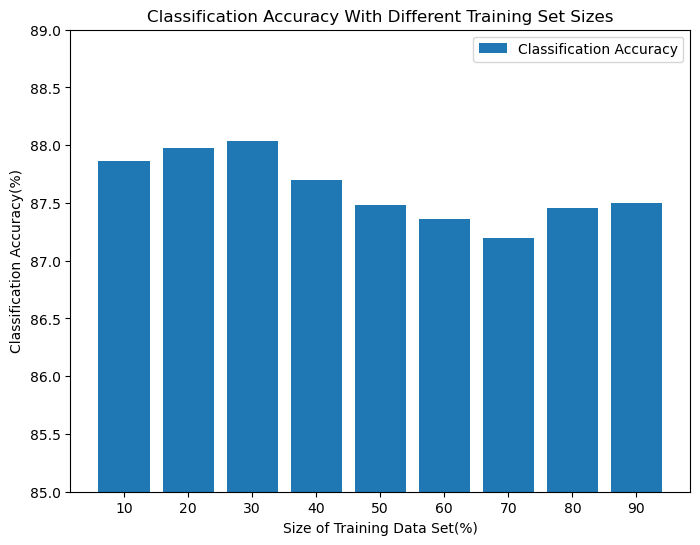

In [195]:
plt.figure(figsize=(8,6),dpi=100)
x_vals = [data[0] for data in int_class_acc_diff_training_sizes]
y_vals = [(data[1]/5000)*100 for data in int_class_acc_diff_training_sizes]
# Total correct is out of 5,000 values

plt.bar(x_vals,y_vals,width=8,label='Classification Accuracy')
plt.xticks(x_vals)
plt.xlabel('Size of Training Data Set(%)')
plt.ylabel('Classification Accuracy(%)')
plt.title('Classification Accuracy With Different Training Set Sizes')
plt.legend()

# Set the y-axis range
plt.ylim(85, 89)

plt.show()

As we can see, the classifier accuracy did not change that much when using from `10%` to `90%` of the total data as training data, staying in between `87-88%`. This is likely due to the fact that even just `10%` of the `movie_review` data contains `2,500` movie reviews, which is a lot of data and allows our classifier to perform well. Let's look at how our classifier performs when only given a really small percentage of the total data for training. We will look at `0.5%` and `1.0%` to see if the classifier struggles with such a low amount of training data.

In [62]:
def generate_class_acc(training_size):
    train_df, test_df = train_test_split(movies, train_size=training_size,test_size=0.1, random_state=1)
    movie_word_occurences = count_word_occurences(train_df)
    valid_words = list(movie_word_occurences.index)
    results = test_classifier(test_df,movie_word_occurences,valid_words)
    
    return results

In [63]:
results_005 = generate_class_acc(0.005)
results_01 = generate_class_acc(0.01)

In [68]:
print(results_005[-1])
print(results_01[-1])

1749 / 2500 = 69.96%
1745 / 2500 = 69.8%


We can see that with a much smaller training set, our classifier performs at a reduced success rate, at just under `70%`.

## Analyzing Rotten Tomatoes Audience Reviews for Star Wars: The Force Awakens With Our Training Data

The new Star Wars sequels are contorversial so the audience reviews should provide good data to analyze both positive and negative reviews...let's see how well our classifier can predict whether or not the review is a positive or negative review.

There are many reviews, to make this task faster we will have to use `requests` library to scrape all of our data before we can process it.

We will start by looking at how the webpage for the audience is constructed. We can see that the page has a pretty straighforward layout -- in a list/forum layout with a review out of 5 stars, followed by the text review underneath it. All of the audience reviews on Rotten Tomatoes' website give a movie review out of 5 stars, let's assume that anything `under 3 stars is negative`, and anything `3 stars and over is positive`. 

In [22]:
from IPython.display import Image

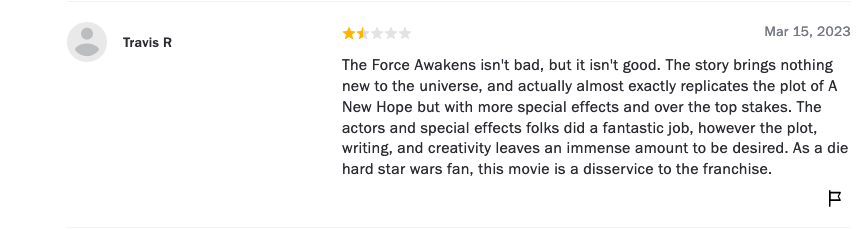

In [23]:
Image(filename='audience_review_display.png')

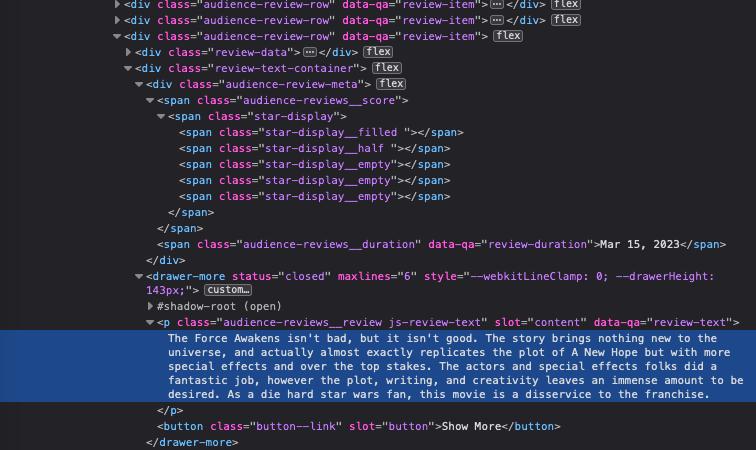

In [24]:
Image(filename='audience_review_html.png')

We can see that the stars are displayed underneath the `span` class `star-display`, with each of the 5 stars given a value of `star-display__filled`, `star-display__half` or `star-display__empty`.

The function `calculate_review_score()` will take in an array of strings that will represent these star ratings, and will calculate the `float score out of 5` to help determine the sentiment of the review, as well as whether or not the review is positive, negative, or neutral.

In [25]:
def calculate_review_score(star_rating):
    rating = 0.0
    for star in star_rating:
        if star == 'star-display__filled': # Filled stars count as 1.0/5.0
            rating += 1.0
        elif star == 'star-display__half': # Half stars count as 0.5/5.0
            rating += 0.5
        # And Empty stars do not add onto the rating score, so do not consider
        
    if rating < 3.0: return (rating,'negative')
    else: return (rating,'positive')

In [28]:
def predict_movie_review_sentiments(reviews_link):
    # Grab data, convert to BeautifulSoup
    audience_reviews_html = requests.get(reviews_link).text
    soup = BeautifulSoup(audience_reviews_html)

    # Reviews have the id audience-review-row', under the div class 'review_table'
    # Grab every div with that class name
    review_table = soup.find('div',class_='review_table')
    audience_review_row = review_table.find_all(class_='audience-review-row')
    
    # We now have the html in which each review and its star rating is contained
    # The star ratings are under the span class 'star-display' and the text for each review is under
    # the 'p' tag class of 'audience-reviews__review js-review-text'. We want to grab the class of
    # 'star-display', which will be 'star-display__filled','star-display__half', or 'star-display__empty.
    # Lastly, we can then grab the actual text of the review by using the '.text' function to get the text 
    # of 'audience-reviews__review js-review-text'.
    audience_reviews = []
    for row in audience_review_row:
        star_displays = (row.find(class_='star-display').find_all('span'))
        stars = [star.get('class')[0] for star in star_displays] 
        review_text = row.find(class_='audience-reviews__review js-review-text').text
        audience_reviews.append((stars,review_text))
        
    # Now with our raw data collected, we can use the function 'calculate_review_score()' to convert the 
    # star rating into a sentiment, and then use our 'rev_probs()' function to predict the sentiment
    # of the review. Again these reviews will contain words that do not appear in our original training
    # dataset, so we will have to drop all non-valid words again.
    correct = 0
    results =[]
    for review in audience_reviews:
        actual = calculate_review_score(review[0])
        predicted = rev_probs(remove_non_valid_words(review[1],valid_words_no_stop_words),training_data_no_stop_words)
        results.append((actual,predicted))
        if actual[1]==predicted[1]:
            correct+=1
    results.append(('{:} / {:} = {:%}'.format(correct,len(audience_reviews),(correct/len(audience_reviews)))))
    
    return results

In [29]:
the_force_awakens_reviews_link = 'https://www.rottentomatoes.com/m/star_wars_episode_vii_the_force_awakens/reviews?type=user'
predict_movie_review_sentiments(the_force_awakens_reviews_link)

[((3.5, 'positive'), (array([-403.13342214, -401.4830315 ]), 'negative')),
 ((1.0, 'negative'), (array([-39.42856305, -37.49206231]), 'negative')),
 ((4.0, 'positive'), (array([-194.89231265, -203.44207067]), 'positive')),
 ((0.5, 'negative'), (array([-62.07234535, -58.02982335]), 'negative')),
 ((0.5, 'negative'), (array([-91.68532498, -90.16399463]), 'negative')),
 ((3.0, 'positive'), (array([-546.12068737, -544.72976662]), 'negative')),
 ((4.0, 'positive'), (array([-58.18345325, -55.60121717]), 'negative')),
 ((1.5, 'negative'), (array([-222.28448005, -215.79313008]), 'negative')),
 ((0.5, 'negative'), (array([-45.48987657, -42.78913467]), 'negative')),
 ((1.0, 'negative'), (array([-602.89627412, -592.33453963]), 'negative')),
 ((0.5, 'negative'), (array([-29.71791771, -27.23579679]), 'negative')),
 ((1.0, 'negative'), (array([-80.61679937, -78.98759446]), 'negative')),
 ((3.5, 'positive'), (array([-122.71693466, -120.76040719]), 'negative')),
 ((1.0, 'negative'), (array([-103.52107

## Goodfellas

In [30]:
goodfellas_reviews_link = 'https://www.rottentomatoes.com/m/1032176-goodfellas/reviews?type=user'
predict_movie_review_sentiments(goodfellas_reviews_link)

[((4.5, 'positive'), (array([-30.88429016, -32.01235456]), 'positive')),
 ((5.0, 'positive'), (array([-35.51472263, -35.90377978]), 'positive')),
 ((4.0, 'positive'), (array([-220.62909628, -227.23487152]), 'positive')),
 ((4.0, 'positive'), (array([-84.30009488, -83.73983447]), 'negative')),
 ((1.5, 'negative'), (array([-180.11245107, -170.56200335]), 'negative')),
 ((4.5, 'positive'), (array([-468.79085797, -474.02508744]), 'positive')),
 ((5.0, 'positive'), (array([-48.43015334, -52.25694471]), 'positive')),
 ((5.0, 'positive'), (array([-291.70031525, -295.27890865]), 'positive')),
 ((5.0, 'positive'), (array([-51.71196113, -52.82125074]), 'positive')),
 ((4.5, 'positive'), (array([-307.14617889, -308.67342814]), 'positive')),
 ((5.0, 'positive'), (array([-32.96274054, -34.72687366]), 'positive')),
 ((5.0, 'positive'), (array([-39.58612989, -42.37995287]), 'positive')),
 ((5.0, 'positive'), (array([-68.83743258, -67.7003618 ]), 'negative')),
 ((5.0, 'positive'), (array([-155.9210824

## Heat

In [31]:
heat_reviews_link = 'https://www.rottentomatoes.com/m/heat_1995/reviews?type=user'
predict_movie_review_sentiments(heat_reviews_link)

[((1.5, 'negative'), (array([-288.16739339, -278.86271068]), 'negative')),
 ((0.5, 'negative'), (array([-341.04460265, -331.71664366]), 'negative')),
 ((5.0, 'positive'), (array([-279.66232191, -279.39990126]), 'negative')),
 ((4.0, 'positive'), (array([-97.05304407, -97.32962229]), 'positive')),
 ((5.0, 'positive'), (array([-141.20091102, -145.03434514]), 'positive')),
 ((5.0, 'positive'), (array([-9.42237676, -8.65690878]), 'negative')),
 ((5.0, 'positive'), (array([-40.04435724, -38.406906  ]), 'negative')),
 ((3.5, 'positive'), (array([-177.18945586, -172.45160376]), 'negative')),
 ((2.0, 'negative'), (array([-166.82954083, -163.5397588 ]), 'negative')),
 ((5.0, 'positive'), (array([-201.48944069, -198.48605414]), 'negative')),
 ((3.0, 'positive'), (array([-33.53064361, -33.97119172]), 'positive')),
 ((5.0, 'positive'), (array([-53.0394637 , -54.37510344]), 'positive')),
 ((4.5, 'positive'), (array([-211.58849743, -217.99758491]), 'positive')),
 ((5.0, 'positive'), (array([-262.162

## Pulp Fiction

In [32]:
pulp_fiction_reviews_link = 'https://www.rottentomatoes.com/m/pulp_fiction/reviews?type=user'
predict_movie_review_sentiments(pulp_fiction_reviews_link)

[((5.0, 'positive'), (array([-11.96954536, -12.54712263]), 'positive')),
 ((4.0, 'positive'), (array([-400.87740577, -405.08173106]), 'positive')),
 ((5.0, 'positive'), (array([0.51055912, 1.        ]), 'negative')),
 ((4.5, 'positive'), (array([-165.62645228, -170.83974933]), 'positive')),
 ((5.0, 'positive'), (array([-40.21425101, -40.13213004]), 'negative')),
 ((2.0, 'negative'), (array([-108.72342406, -106.41832954]), 'negative')),
 ((3.5, 'positive'), (array([-1631.46698725, -1627.1304492 ]), 'negative')),
 ((3.5, 'positive'), (array([-1478.81167865, -1476.65561515]), 'negative')),
 ((5.0, 'positive'), (array([-1648.11075496, -1700.36188345]), 'positive')),
 ((5.0, 'positive'), (array([-83.4994519 , -86.79873215]), 'positive')),
 ((5.0, 'positive'), (array([-62.95705585, -63.34106597]), 'positive')),
 ((5.0, 'positive'), (array([-446.93550435, -453.82327734]), 'positive')),
 ((4.5, 'positive'), (array([-290.50334341, -286.29708009]), 'negative')),
 ((5.0, 'positive'), (array([-108

## The Usual Suspects

In [33]:
the_usual_suspects_reviews_link = 'https://www.rottentomatoes.com/m/usual_suspects/reviews?type=user'
predict_movie_review_sentiments(the_usual_suspects_reviews_link)

[((2.5, 'negative'), (array([-60.30806412, -58.01716227]), 'negative')),
 ((3.5, 'positive'), (array([-240.24685035, -239.7139192 ]), 'negative')),
 ((4.5, 'positive'), (array([-57.78277323, -57.51674357]), 'negative')),
 ((4.5, 'positive'), (array([-500.22255412, -504.93481592]), 'positive')),
 ((5.0, 'positive'), (array([-205.24706784, -213.28730894]), 'positive')),
 ((5.0, 'positive'), (array([-312.23681262, -318.73785632]), 'positive')),
 ((4.0, 'positive'), (array([-24.0224711 , -24.67560603]), 'positive')),
 ((4.0, 'positive'), (array([-41.5012847 , -44.90428769]), 'positive')),
 ((5.0, 'positive'), (array([-106.25755385, -106.67969598]), 'positive')),
 ((5.0, 'positive'), (array([-114.54886061, -115.36779685]), 'positive')),
 ((5.0, 'positive'), (array([-185.7452516, -192.4229999]), 'positive')),
 ((5.0, 'positive'), (array([-25.15109872, -29.02925734]), 'positive')),
 ((4.5, 'positive'), (array([-21.12766866, -22.74959195]), 'positive')),
 ((5.0, 'positive'), (array([-132.56220

We can see that the `rev_probs()` function with our training data set actually performs well when looking at reviews for movies found on the Internet. The Rotten Tomatoes website is set up in such a way that only 20 reviews show at once before new ones being dynamically reloaded onto the same webpage when clicking the 'Next', so we did not have a huge testing set. But out of the 100 reviews, our predictor was able to correctly guess the sentiment of `72` out of `100` movie reviews, which is a good result. When analyzing the results of our predictor, the fact that we are only looking at single words to calculate our prediction must be taken into context, as phrases like 'ridiculously good' or 'hilariously bad' are actually postive and negative statements, respectively, but they could skew the predictor the wrong way. 

## Presidential Debates - Predicting Who The Speaker Is

We will start by grabbing all of the transcripts from the link below using pythons `requests.get()` function. After that we will grab every link from the webpage, and grab all of the html under the `div id='content-sm'`. This `div` contains all of the data that we are looking for. Once that is doen we will write this all to a folder named `Debate_Transcripts` for quick access.

In [87]:
debates_url = "https://www.debates.org/voter-education/debate-transcripts/"
september_debate_file = 'Debate_Transcripts/September 26, 2016 Debate Transcript.html'
october_debate_file = 'Debate_Transcripts/October 19, 2016 Debate Transcript.html'

In [ ]:
text = requests.get(debates_url).text
soup = BeautifulSoup(text)
links_found = soup.find('ul',class_='children').findAll('a')

debate_names = []
links = []

for l in links_found:
    debate_names.append(l.text)
    links.append('https://www.debates.org' + l.get('href'))
    
    
folder_name = 'Debate_Transcripts'

for dm, l in zip(debate_names,links):
    d = requests.get(l).text
    s = BeautifulSoup(d)
    transcript = s.find('div', {'id': 'content-sm'})
    
    # When writing to the .html file, setting the parameter encoding='utf-8' was not working, so had to remove
    # all chars 128-256 to remove non-ascii characters
    # The .join() method here allows all of the chars to be added to the string if and only if they have a
    # value less than 128, which is all of the normal characters
    transcript_clean = ''.join(c for c in str(transcript) if ord(c) < 128)
    
    # Write to html file under the folder
    with open(folder_name + '/' + dm +'.html','w') as file:
        file.write(str(transcript_clean))
    
    # Write to txt file under folder
    with open(folder_name + '/' + dm +'.txt','w') as file:
        file.write(str(transcript.text)) 

With our debates data collected, we will now analyze one of these transcripts. We will look at two different debates preceding the 2016 presidental election, between Donald Trump and Hillary Clinton. These debates occurred on `September 26, 2016`, moderated by `Lester Holt` and `October 19, 2016`, moderated by `Chris Wallace`. 

We will first want to make word counts for each speaker, so that we can apply our Bayesian predictor. We will start with the debate from September.

In [88]:
with open(september_debate_file,encoding='utf8') as fp:
    soup = BeautifulSoup(fp, 'html.parser')
s = soup.text
#we want to remove the following characters and string
punc = ',.;:!?"'
otherbadwords = ['--','[applause]','[inaudible]','[laughter]','[crosstalk]']

# first remove punctuation
for p in punc: 
    s = s.replace(p,'')#remove punctuation

s = s.replace('—',' ')

# next remove formating words that aren't helpful
for w in otherbadwords: 
    s = s.replace(w,'')

# restore colons after speaker names since these were just removed
for sp in speakers: 
    s = s.replace(sp,sp+':')  

tags_september = [ sp.lower()+':' for sp in speakers ]

#make all lower case
s = s.lower()

words_september = s.split()

Now that we have gone through the file and moved all of its contents into a list of strings free of punctuation, we can now create word counts for each speaker. We also will use the first `70%` of the file as our training data, and then the remaining `30%` as our testing data. Lets find where one of speakers stops speaking around the `70%` mark in `words_september`:

In [106]:
print(int(len(words_september)*.7))
words_september[int(len(words_september)*.7):(int(len(words_september)*.71))]

11916


['that',
 'was',
 'china',
 'whether',
 'it',
 'was',
 'another',
 'country',
 'we',
 'dont',
 'know',
 'because',
 'the',
 'truth',
 'is',
 'under',
 'president',
 'obama',
 'weve',
 'lost',
 'control',
 'of',
 'things',
 'that',
 'we',
 'used',
 'to',
 'have',
 'control',
 'over',
 'we',
 'came',
 'in',
 'with',
 'the',
 'internet',
 'we',
 'came',
 'up',
 'with',
 'the',
 'internet',
 'and',
 'i',
 'think',
 'secretary',
 'clinton',
 'and',
 'myself',
 'would',
 'agree',
 'very',
 'much',
 'when',
 'you',
 'look',
 'at',
 'what',
 'isis',
 'is',
 'doing',
 'with',
 'the',
 'internet',
 'theyre',
 'beating',
 'us',
 'at',
 'our',
 'own',
 'game',
 'isis',
 'so',
 'we',
 'have',
 'to',
 'get',
 'very',
 'very',
 'tough',
 'on',
 'cyber',
 'and',
 'cyber',
 'warfare',
 'it',
 'isit',
 'is',
 'a',
 'huge',
 'problem',
 'i',
 'have',
 'a',
 'son',
 'hes',
 '10',
 'years',
 'old',
 'he',
 'has',
 'computers',
 'he',
 'is',
 'so',
 'good',
 'with',
 'these',
 'computers',
 'its',
 'unbelie

We can see that Trump is speaking here, and this is a good place to cut off our training and testing data. Upon further review of the file, we discovered that Trump stops speaking here at the `12,082nd` index of `words_september`.

In [109]:
print(words_september[12082]) # This is where we will cutoff our training and testing data
print(12082/len(words_september))

holt:
0.7097456382541267


We can see that at the `12,082nd` index, our data for this particular transcript will be divided into about a `70/30` split. From there we can denote the indices that will be used for the training and testing data.

In [114]:
words_september_train = words_september[:12082]
words_september_test = words_september[12082:]

In [91]:
# identify the 3 speakers: Holt is the debate moderator
speakers = ['HOLT','CLINTON','TRUMP']

h_september = []#words used by holt
c_september = []#words used by clinton
t_september = []#words used by trump

#let variable 'current' denote the current speaker, and update it as one goes through the text
current =[]

for w in words_september_train:# i.e., consider each word
    if  w == tags_september[0]: #i.e., if w = holt:
        current = h_september 
    elif w == tags_september[1]: #i.e., if w = clinton:
        current = c_september
    elif w == tags_september[2]: #...
        current = t_september

    # if the word is not a speaker's name, add word to the current speaker's list of words    
    else: 
        current.append(w) 

holt_counter_september = Counter(h_september)
trump_counter_september = Counter(t_september)
clinton_counter_september = Counter(c_september)

speakersDict_september = {'Holt':holt_counter_september,
                          'Trump':trump_counter_september,
                          'Clinton':clinton_counter_september}

speakers_df_september = pd.DataFrame(speakersDict_september).fillna(0).sort_values(by=['Holt','Trump','Clinton'],ascending=False)
speakers_df_september[['Holt','Trump','Clinton']] = speakers_df_september[['Holt','Trump','Clinton']].astype(int)

speakers_df_september

Holt  Trump  Clinton
the          96    293      251
to           82    256      238
you          64    197       76
and          43    276      204
of           39    171      135
...         ...    ...      ...
bet           0      0        1
democracy     0      0        1
plant         0      0        1
doubts        0      0        1
depended      0      0        1

[2354 rows x 3 columns]

With our training data set, we can now attempt to predict speakers for each passage. To find each passage for each speaker, we will use `regex` to match on one of the speakers names followed by a colon. To make sure we end our regex search when another of the speakers starts talking, we will use a lookahead assertion that checks if the next text is either the name of another speaker followed by a colon.

In [134]:
testing_data = ' '.join(words_september_test)

In [135]:
# For each speaker we want to first match on their name followed by ':'
# We then want to match any white space, non-greedily
# Finally we want to stop our match when a different person speaks, '(?=(trump:|clinton:|$))' is 
# a lookahead assertion that matches either "trump:", "clinton:", or the end of the string

holt_RE = 'holt:\s*(.*?)(?=(trump:|clinton:|$))' 
trump_RE = 'trump:\s*(.*?)(?=(holt:|clinton:|$))'
clinton_RE = 'clinton:\s*(.*?)(?=(holt:|trump:|$))'

In [143]:
holt_texts = [text[0] for text in re.findall(holt_RE,testing_data)]
trump_texts = [text[0] for text in re.findall(trump_RE,testing_data)]
clinton_texts = [text[0] for text in re.findall(clinton_RE,testing_data)]

In [152]:
def rev_probs_debates(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['Holt','Trump','Clinton']].add(1)
    
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(3)
    prod[0] = laplace_training_data['Holt'].sum()/(tot)
    prod[0] = laplace_training_data['Trump'].sum()/(tot)
    prod[0] = laplace_training_data['Clinton'].sum()/(tot)
    
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['Holt','Trump','Clinton'][np.argmax(prod)]) 

With our function `rev_probs_debates()` function created, let's test it out. 

In [180]:
def debate_speaker_acc(speaker_texts,speaker_name,training_data):
    correct = 0
    total_transcripts = len(speaker_texts)
    for line in speaker_texts:
        actual = speaker_name
        prediction = rev_probs_debates(line,training_data)[1]
        if actual == prediction:
            correct += 1
    return (correct,total_transcripts,(correct/total_transcripts))

In [182]:
holt_results = debate_speaker_acc(holt_texts,'Holt',speakers_df_september)
trump_results = debate_speaker_acc(trump_texts,'Trump',speakers_df_september)
clinton_results = debate_speaker_acc(clinton_texts,'Clinton',speakers_df_september)

In [198]:
print('{:} Results: {:} %'.format('Holt',holt_results[2]*100))
print('{:} Results: {:} %'.format('Trump',trump_results[2]*100))
print('{:} Results: {:} %'.format('Clinton',clinton_results[2]*100))

Holt Results: 87.17948717948718 %
Trump Results: 95.65217391304348 %
Clinton Results: 86.95652173913044 %


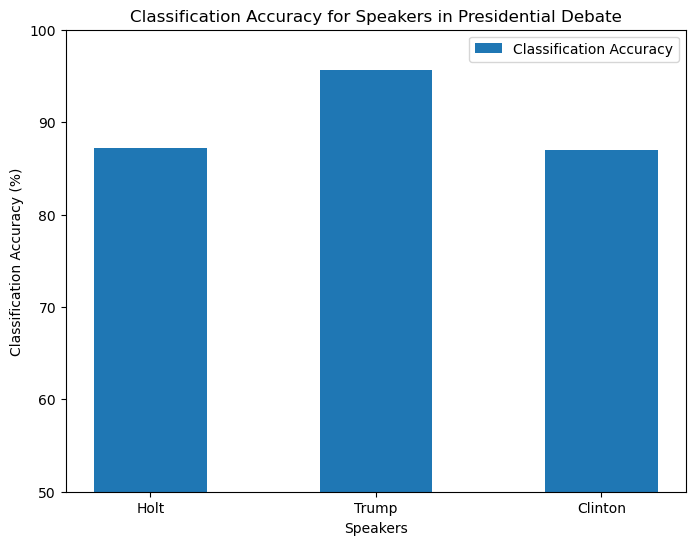

In [197]:
plt.figure(figsize=(8,6),dpi=100)
x_values = ['Holt','Trump','Clinton']
y_values = [holt_results[2]*100,trump_results[2]*100,clinton_results[2]*100]
plt.bar(x_values,y_values,width=0.5,label='Classification Accuracy')
plt.xlabel('Speakers')
plt.ylabel('Classification Accuracy (%)')
plt.legend()
plt.title('Classification Accuracy for Speakers in Presidential Debate')
plt.ylim(50,100)
plt.show()

We can see that our classifier is pretty sucessful when classifying the data, correctly classifying the speakers as being either `Holt` or `Clinton` over `86%` of the time, while performing excellently at classifying whether or not `Trump` is speaking at over a `95%` success rate.

Now we will see how our classifier performs with this training data from the `September` debates, but now with different quotes spoken by both Trump and Clinton from their debate on `October 19, 2016`.

In [317]:
speakers_october = ['WALLACE','CLINTON','TRUMP']

In [318]:
with open(october_debate_file,encoding='utf8') as fp:
    soup = BeautifulSoup(fp, 'html.parser')
s_october = soup.text
#we want to remove the following characters and string
punc = ',.;:!?"'
otherbadwords = ['--','[applause]','[inaudible]','[laughter]','[crosstalk]']

# first remove punctuation
for p in punc: 
    s_october = s_october.replace(p,'')#remove punctuation

s_october = s_october.replace('—',' ')

# next remove formating words that aren't helpful
for w in otherbadwords: 
    s_october = s_october.replace(w,'')

# restore colons after speaker names since these were just removed
for sp in speakers_october: 
    s_october = s_october.replace(sp,sp+':')  

tags_october = [ sp.lower()+':' for sp in speakers_october ]

#make all lower case
s_october = s_october.lower()

words_october = s_october.split()

We will create a new function `rev_probs_debates_oct()` that will only predict whether the speaker is Trump or Clinton.

In [259]:
def rev_probs_debates_oct(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['Trump','Clinton']].add(1)
    
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(2)
    prod[0] = laplace_training_data['Trump'].sum()/(tot)
    prod[0] = laplace_training_data['Clinton'].sum()/(tot)
    
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['Trump','Clinton'][np.argmax(prod)]) 

And from the `October` debate, we will use `regex` to find all Trump and Clinton quotes.

In [260]:
testing_data_october = ' '.join(words_october)
trump_texts_october = [text[0] for text in re.findall(trump_RE,testing_data_october)]
clinton_texts_october = [text[0] for text in re.findall(clinton_RE,testing_data_october)]

Now we will use all the words from the `September` debate as a list of valid words, any words that did not appear in our training data from that debate will not be considered.

In [303]:
valid_words_speakers = list(speakers_df_september.index)

The function `remove_non_valid_words_oct()` will remove any words that do not appear in the `September` debate.

In [313]:
def remove_non_valid_words_oct(text,valid_words):   
    return ' '.join([word for word in text.split(' ') if word in valid_words])

Now let's test our classifier on quotes by both Trump and Clinton taken from their `October` debate.

In [322]:
def debate_speaker_acc_october(speaker_texts,speaker_name,training_data,valid_words):
    correct = 0
    total_transcripts = len(speaker_texts)
    for line in speaker_texts:
        line = remove_non_valid_words_oct(line,valid_words)
        actual = speaker_name
        prediction = rev_probs_debates(line,training_data)[1]
        if actual == prediction:
            correct += 1
    return (correct,total_transcripts,(correct/total_transcripts))

In [324]:
trump_results_oct = debate_speaker_acc_october(trump_texts_october,'Trump',
                                               speakers_df_september,valid_words_speakers)
clinton_results_oct = debate_speaker_acc_october(clinton_texts_october,'Clinton',
                                                 speakers_df_september,valid_words_speakers)

In [325]:
print('{:} Results: {:} %'.format('Trump',trump_results_oct[2]*100))
print('{:} Results: {:} %'.format('Clinton',clinton_results_oct[2]*100))

Trump Results: 87.87878787878788 %
Clinton Results: 78.78787878787878 %


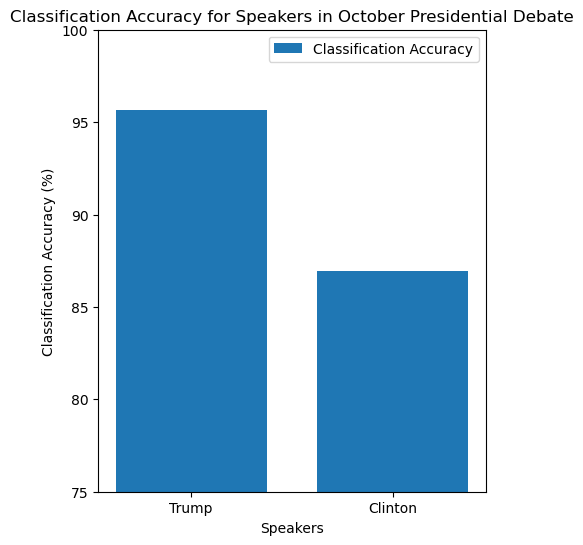

In [336]:
plt.figure(figsize=(5,6),dpi=100)
x_values = ['Trump','Clinton']
y_values = [trump_results[2]*100,clinton_results[2]*100]
plt.bar(x_values,y_values,width=0.75,label='Classification Accuracy')
plt.xlabel('Speakers')
plt.ylabel('Classification Accuracy (%)')
plt.legend()
plt.title('Classification Accuracy for Speakers in October Presidential Debate')
plt.ylim(75,100)
plt.show()

Again we can see that our classifier still performs well when we look at a different debate, correctly classifying Trump as the speaker `87.8%` of the time, and Clinton `78.7%` of the time.

Now we will look at some quotes found on the internet from both Trump and Clinton. I found these quotes at this website: `www.goodreads.com` .

### Trump Quotes

In [341]:
tQuote1 = """As long as you are going to be thinking anyway, think big."""
tQuote2 = """Show me someone without an ego, and I'll show you a loser."""
tQuote3 = """I've read hundreds of books about China over the decades. I know the Chinese. I've made a lot of money with the Chinese. I understand the Chinese mind."""
tQuote4 = """MY STYLE of deal-making is quite simple and straightforward. I aim very high, and then I just keep pushing and pushing and pushing to get what I’m after."""
tQuote5 = """Get going. Move forward. Aim High. Plan a takeoff. Don't just sit on the runway and hope someone will come along and push the airplane. It simply won't happen. Change your attitude and gain some altitude. Believe me, you'll love it up here."""

print(rev_probs_debates(remove_non_valid_words_oct(tQuote1,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote2,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote3,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote4,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote5,valid_words_speakers),speakers_df_september))

(array([-54.3954723 , -49.3377515 , -50.93564867]), 'Trump')
(array([-50.99941266, -49.15526827, -50.558975  ]), 'Trump')
(array([-103.69161121,  -92.97147685,  -95.09058616]), 'Trump')
(array([-113.91946988, -107.45245665, -109.69811549]), 'Trump')
(array([-135.42414015, -130.61252038, -127.95015742]), 'Clinton')


### Clinton Quotes

In [342]:
cQuote1 = """Human rights are women’s rights, and women’s rights are human rights. Let us not forget that among those rights are the right to speak freely--and the right to be heard."""
cQuote2 = """Faith is like stepping off a cliff and expecting one of two outcomes- you will either land on solid ground or you will be taught to fly."""
cQuote3 = """Early on the morning of November 9, when it came time to decide on what I’d say in my concession speech, I remembered those words. Inspired by them, I wrote these: “To all the little girls who are watching this, never doubt that you are valuable and powerful and deserving of every chance and opportunity in the world to pursue and achieve your own dreams."""
cQuote4 = """One thing I’ve learned over the years is how easy it is for some people to say horrible things about me when I’m not around, but how hard it is for them to look me in the eye and say it to my face."""
cQuote5 = """In this world and the world of tomorrow, we must go forward together or not at all."""

print(rev_probs_debates(remove_non_valid_words_oct(cQuote1,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote2,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote3,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote4,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote5,valid_words_speakers),speakers_df_september))

(array([-114.2385202 , -110.23297543, -109.07296939]), 'Clinton')
(array([-115.09611132, -108.99297063, -112.90256553]), 'Trump')
(array([-252.94268791, -235.00928265, -236.06301522]), 'Trump')
(array([-240.0733645 , -210.67126568, -219.65636849]), 'Trump')
(array([-91.70403494, -82.23162848, -81.89287419]), 'Clinton')


We can see that our classifier still performed well with the Trump quotes, even though they were taken from books he has written and are not of the context of a presidential debate. Our classifier struggled with quotes from Clinton, although this should be expected as we are not using training data from any books that she has written.

## Conclusion

In this project we built a Bayesian classifer to predict what the sentiment of a movie review was based off of a training dataset that contained reviews. We found that our predictor was pretty accurate, able to predict the sentiment of around `84%` of movie reviews. When we removed stop words from our training data, our model performed even better, correctly classifying almost `87%` of the movie reviews.

We also saw that there were differences in classification accuracy when we reduced the size of our training set. When we only gave our model between `125-250` movie reviews for a training set, it was only able to predict the sentiment correctly about `69%` of the time. The accuracy of our model did not change much when the size of the training set was increased to `2,500` movie reviews and higher, staying at around a `87-88%` success rate.

Our model was also able to do a pretty good job predicting what the sentiment of random movie reviews found online would be, correctly classifying `72/100` reviews found on Rotten Tomatoes.

We then analyzed presidential debates, and trained our model to try to predict who the speaker was during one of these debates. We analyzed two debates from the `2016` presidential election, both featuring candidates `Donald Trump` and `Hillary Clinton`. We found that our predictor was very successful at doing this, able to predict when Clinton was speaking at almost `87%` of time. Our model performed excellently when trying to predict if Trump was speaking, correctly classifying quotes fom him at over `95%` of the time. These high success rates can be partly explained by the fact that the two candidates are both speaking about limited topics inside of a confined and professional environment, and are very likely to say words that directly correlate to their campaign's messages. When looking at a different debate between these two, we saw that our model was slightly less successful and was able to classify Trump and Clinton quotes at `87%` and `78%`, respectfully.

When we moved outside of a debate environment and analyzed quotes from books authored by these two candidates, we saw that our model was not as successful and was only able to correctly classify `6/10` quotes.

## Code

### Modules

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import string
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

### Movie Reviews

In [ ]:
movies = pd.read_csv('movie_reviews.zip')
len(movies)

train_df, test_df = train_test_split(movies, train_size=0.8, random_state=1)
len(train_df)

def clean_string(dirty):
    replacements = [('<br />',''),('\\',''),('.',' '),('!',''),('?',''),('(',''),(')',''),('-',' '),('"',''),(',','')]
    dirty = dirty.lower() # Make all of the words lowercase for consistent results
    for char, replace in replacements:
        if char in dirty:
            dirty = dirty.replace(char, replace) # If any unwanted symbols appear replace them with blank space
    return dirty


def count_word_occurences(movie_dataframe):
    # Create empty Counters for positive and negative reviews
    positive_counter = Counter()
    negative_counter = Counter()

    # Iterate through each row of the movies dataframe
    for index, row in movie_dataframe.iterrows():
        # Clean the review string
        clean_review = clean_string(row['review'])
        words = clean_review.split()
        # Add words to the appropriate counter based on the sentiment
        if row['sentiment'] == 'positive':
            positive_counter.update(words)
        elif row['sentiment'] == 'negative':
            negative_counter.update(words)
            
    word_counts = pd.DataFrame(columns=['negative', 'positive'])

    # Iterate through each word in the positive and negative counters
    for word in set(list(positive_counter.keys()) + list(negative_counter.keys())):
        # Add a new row to the dataframe with the count for this word
        word_counts.loc[word] = [negative_counter[word], positive_counter[word]]

    # Fill any missing values with 0
    word_counts = word_counts.fillna(0)
    
    word_counts_sorted = word_counts.sort_values(by=['positive', 'negative'], ascending=False)
    
    return word_counts_sorted


#movie_word_occurences = count_word_occurences(train_df)
#movie_word_occurences.to_csv('movie_review_training_data.csv')

training_data_with_stop_words = pd.read_csv('movie_review_training_data.csv')
training_data_with_stop_words = training_data_with_stop_words.set_index('Unnamed: 0').rename_axis('', axis='index')
training_data_with_stop_words

### Testing

In [ ]:
def rev_probs(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['positive','negative']].add(1)
    
    # Compute the prior probabilities of the positive and negative classes using the training data
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(2)
    prod[0] = laplace_training_data['negative'].sum()/(tot)
    prod[0] = laplace_training_data['positive'].sum()/(tot)
    
    # Compute 'log' probabilites, add them to prod array:
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['positive','negative'][np.argmax(prod)]) 

valid_words_with_stop_words = list(training_data_with_stop_words.index)

def remove_non_valid_words(review_string,valid_words):
    review = clean_string(review_string).split()
    for word in review:
        if word not in valid_words:
            review = [x for x in review if x != word]
    review1 = ' '.join(review)
    return review1


def test_classifier(test_set,training_data,valid_words):
    results_list = []
    correct = 0
    testSize = len(test_df)
    
    for i in range(len(test_df)):
        # Retrive actual sentiment
        actual = test_df.iloc[i]['sentiment']
        # Remove non-valid words, then usse cleaned string and training data to make prediction
        prediction = rev_probs(remove_non_valid_words(test_df.iloc[i]['review'],valid_words),training_data)
        if actual == prediction[1]:
            correct += 1
        results_list.append((actual,prediction))
    # Add percentage correct to results
    results_list.append('{:} / {:} = {:}%'.format(correct,testSize,(correct/testSize)*100))
    
    return results_list


#results_list_with_stop_words = test_classifier(test_df,training_data_with_stop_words,valid_words_with_stop_words)

#with open('movie_review_testing_results_with_stop_words.txt','w') as f:
#    for item in results_list_with_stop_words:
#        f.write(str(item))
#        f.write('\n')

with open('movie_review_testing_results_with_stop_words.txt','r') as f:
    results_with_stop_words = f.read().splitlines()
    
results_with_stop_words[-1]

### Testing Without Stop Words

In [ ]:
with open ('stopwords.txt') as f:
    stops = f.read()

stop_words = stops.split(',')

training_data_no_stop_words = pd.read_csv('movie_review_training_data.csv')
training_data_no_stop_words = training_data_no_stop_words.set_index('Unnamed: 0').rename_axis('', axis='index')
training_data_no_stop_words = training_data_no_stop_words.drop(stop_words,errors='ignore')

valid_words_no_stop_words = list(training_data_no_stop_words.index)

#results_list_no_stop_words = test_classifier(test_df,training_data_no_stop_words,valid_words_no_stop_words)

#with open('movie_review_testing_results_no_stop_words.txt','w') as f:
#    for item in results_list_no_stop_words:
#        f.write(str(item))
#        f.write('\n')

with open('movie_review_testing_results_no_stop_words.txt','r') as f:
    results_no_stop_words = f.read().splitlines()
    
results_no_stop_words[-1]

### Classifying with Different Training Set Sizes

In [ ]:
def generate_classification_accuracy():
    classification_results = []
    
    for i in range (1,10):
        # Start at 10%, then go up to 90%
        training_size = (i / 10.0)
        movies = pd.read_csv('movie_reviews.zip')
        # Split into testing and training datasets
        train_df, test_df = train_test_split(movies, train_size=training_size,test_size=0.1, random_state=1)
        # Get word counts
        movie_word_occurences = count_word_occurences(train_df)
        valid_words = list(movie_word_occurences.index)
        # Classify the reviews in testing dataset
        results = test_classifier(test_df,movie_word_occurences,valid_words)
        classification_results.append((i*10,results[-1]))
    return classification_results

#results = generate_classification_accuracy()

#with open('classification_acc_diff_training_set_size.txt','w') as f:
#    for item in results:
#        f.write(str(item))
#        f.write('\n')

# Retrieve the data for visualization
with open('classification_acc_diff_training_set_size.txt','r') as f:
    class_acc_diff_training_sizes = f.read().splitlines()

int_class_acc_diff_training_sizes = []
for item in class_acc_diff_training_sizes:
    # Extract the integer values from the string
    int1 = int(item.split(',')[0].strip('('))
    int2 = int(item.split('/')[0].split()[-1].replace("'", "").strip())
    int_class_acc_diff_training_sizes.append((int1, int2))


plt.figure(figsize=(8,6),dpi=100)
x_vals = [data[0] for data in int_class_acc_diff_training_sizes]
y_vals = [(data[1]/5000)*100 for data in int_class_acc_diff_training_sizes]
# Total correct is out of 5,000 values

plt.bar(x_vals,y_vals,width=8,label='Classification Accuracy')
plt.xticks(x_vals)
plt.xlabel('Size of Training Data Set(%)')
plt.ylabel('Classification Accuracy(%)')
plt.title('Classification Accuracy With Different Training Set Sizes')
plt.legend()

# Set the y-axis range
plt.ylim(85, 89)

plt.show()


def generate_class_acc(training_size):
    train_df, test_df = train_test_split(movies, train_size=training_size,test_size=0.1, random_state=1)
    movie_word_occurences = count_word_occurences(train_df)
    valid_words = list(movie_word_occurences.index)
    results = test_classifier(test_df,movie_word_occurences,valid_words)
    
    return results

results_005 = generate_class_acc(0.005)
results_01 = generate_class_acc(0.01)


print(results_005[-1])
print(results_01[-1])

### Rotten Tomatoes Reviews

In [ ]:
def calculate_review_score(star_rating):
    rating = 0.0
    for star in star_rating:
        if star == 'star-display__filled': # Filled stars count as 1.0/5.0
            rating += 1.0
        elif star == 'star-display__half': # Half stars count as 0.5/5.0
            rating += 0.5
        # And Empty stars do not add onto the rating score, so do not consider
        
    if rating < 3.0: return (rating,'negative')
    else: return (rating,'positive')

def predict_movie_review_sentiments(reviews_link):
    # Grab data, convert to BeautifulSoup
    audience_reviews_html = requests.get(reviews_link).text
    soup = BeautifulSoup(audience_reviews_html)

    # Reviews have the id audience-review-row', under the div class 'review_table'
    # Grab every div with that class name
    review_table = soup.find('div',class_='review_table')
    audience_review_row = review_table.find_all(class_='audience-review-row')
    
    # We now have the html in which each review and its star rating is contained
    # The star ratings are under the span class 'star-display' and the text for each review is under
    # the 'p' tag class of 'audience-reviews__review js-review-text'. We want to grab the class of
    # 'star-display', which will be 'star-display__filled','star-display__half', or 'star-display__empty.
    # Lastly, we can then grab the actual text of the review by using the '.text' function to get the text 
    # of 'audience-reviews__review js-review-text'.
    audience_reviews = []
    for row in audience_review_row:
        star_displays = (row.find(class_='star-display').find_all('span'))
        stars = [star.get('class')[0] for star in star_displays] 
        review_text = row.find(class_='audience-reviews__review js-review-text').text
        audience_reviews.append((stars,review_text))
        
    # Now with our raw data collected, we can use the function 'calculate_review_score()' to convert the 
    # star rating into a sentiment, and then use our 'rev_probs()' function to predict the sentiment
    # of the review. Again these reviews will contain words that do not appear in our original training
    # dataset, so we will have to drop all non-valid words again.
    correct = 0
    results =[]
    for review in audience_reviews:
        actual = calculate_review_score(review[0])
        predicted = rev_probs(remove_non_valid_words(review[1],valid_words_no_stop_words),training_data_no_stop_words)
        results.append((actual,predicted))
        if actual[1]==predicted[1]:
            correct+=1
    results.append(('{:} / {:} = {:%}'.format(correct,len(audience_reviews),(correct/len(audience_reviews)))))
    
    return results

the_force_awakens_reviews_link = 'https://www.rottentomatoes.com/m/star_wars_episode_vii_the_force_awakens/reviews?type=user'
predict_movie_review_sentiments(the_force_awakens_reviews_link)

goodfellas_reviews_link = 'https://www.rottentomatoes.com/m/1032176-goodfellas/reviews?type=user'
predict_movie_review_sentiments(goodfellas_reviews_link)

heat_reviews_link = 'https://www.rottentomatoes.com/m/heat_1995/reviews?type=user'
predict_movie_review_sentiments(heat_reviews_link)

pulp_fiction_reviews_link = 'https://www.rottentomatoes.com/m/pulp_fiction/reviews?type=user'
predict_movie_review_sentiments(pulp_fiction_reviews_link)

the_usual_suspects_reviews_link = 'https://www.rottentomatoes.com/m/usual_suspects/reviews?type=user'
predict_movie_review_sentiments(the_usual_suspects_reviews_link)

### Presidential Debates

In [ ]:
debates_url = "https://www.debates.org/voter-education/debate-transcripts/"
september_debate_file = 'Debate_Transcripts/September 26, 2016 Debate Transcript.html'
october_debate_file = 'Debate_Transcripts/October 19, 2016 Debate Transcript.html'

text = requests.get(debates_url).text
soup = BeautifulSoup(text)
links_found = soup.find('ul',class_='children').findAll('a')

debate_names = []
links = []

for l in links_found:
    debate_names.append(l.text)
    links.append('https://www.debates.org' + l.get('href'))
    
    
folder_name = 'Debate_Transcripts'

for dm, l in zip(debate_names,links):
    d = requests.get(l).text
    s = BeautifulSoup(d)
    transcript = s.find('div', {'id': 'content-sm'})
    
    # When writing to the .html file, setting the parameter encoding='utf-8' was not working, so had to remove
    # all chars 128-256 to remove non-ascii characters
    # The .join() method here allows all of the chars to be added to the string if and only if they have a
    # value less than 128, which is all of the normal characters
    transcript_clean = ''.join(c for c in str(transcript) if ord(c) < 128)
    
    # Write to html file under the folder
    with open(folder_name + '/' + dm +'.html','w') as file:
        file.write(str(transcript_clean))
    
    # Write to txt file under folder
    with open(folder_name + '/' + dm +'.txt','w') as file:
        file.write(str(transcript.text)) 


with open(september_debate_file,encoding='utf8') as fp:
    soup = BeautifulSoup(fp, 'html.parser')
s = soup.text
#we want to remove the following characters and string
punc = ',.;:!?"'
otherbadwords = ['--','[applause]','[inaudible]','[laughter]','[crosstalk]']

# first remove punctuation
for p in punc: 
    s = s.replace(p,'')#remove punctuation

s = s.replace('—',' ')

# next remove formating words that aren't helpful
for w in otherbadwords: 
    s = s.replace(w,'')

# restore colons after speaker names since these were just removed
for sp in speakers: 
    s = s.replace(sp,sp+':')  

tags_september = [ sp.lower()+':' for sp in speakers ]

#make all lower case
s = s.lower()

words_september = s.split()


print(int(len(words_september)*.7))
words_september[int(len(words_september)*.7):(int(len(words_september)*.71))]

print(words_september[12082]) # This is where we will cutoff our training and testing data
print(12082/len(words_september))

words_september_train = words_september[:12082]
words_september_test = words_september[12082:]

# identify the 3 speakers: Holt is the debate moderator
speakers = ['HOLT','CLINTON','TRUMP']

h_september = []#words used by holt
c_september = []#words used by clinton
t_september = []#words used by trump

#let variable 'current' denote the current speaker, and update it as one goes through the text
current =[]

for w in words_september_train:# i.e., consider each word
    if  w == tags_september[0]: #i.e., if w = holt:
        current = h_september 
    elif w == tags_september[1]: #i.e., if w = clinton:
        current = c_september
    elif w == tags_september[2]: #...
        current = t_september

    # if the word is not a speaker's name, add word to the current speaker's list of words    
    else: 
        current.append(w) 

holt_counter_september = Counter(h_september)
trump_counter_september = Counter(t_september)
clinton_counter_september = Counter(c_september)

speakersDict_september = {'Holt':holt_counter_september,
                          'Trump':trump_counter_september,
                          'Clinton':clinton_counter_september}

speakers_df_september = pd.DataFrame(speakersDict_september).fillna(0).sort_values(by=['Holt','Trump','Clinton'],ascending=False)
speakers_df_september[['Holt','Trump','Clinton']] = speakers_df_september[['Holt','Trump','Clinton']].astype(int)

speakers_df_september

testing_data = ' '.join(words_september_test)

# For each speaker we want to first match on their name followed by ':'
# We then want to match any white space, non-greedily
# Finally we want to stop our match when a different person speaks, '(?=(trump:|clinton:|$))' is 
# a lookahead assertion that matches either "trump:", "clinton:", or the end of the string

holt_RE = 'holt:\s*(.*?)(?=(trump:|clinton:|$))' 
trump_RE = 'trump:\s*(.*?)(?=(holt:|clinton:|$))'
clinton_RE = 'clinton:\s*(.*?)(?=(holt:|trump:|$))'

holt_texts = [text[0] for text in re.findall(holt_RE,testing_data)]
trump_texts = [text[0] for text in re.findall(trump_RE,testing_data)]
clinton_texts = [text[0] for text in re.findall(clinton_RE,testing_data)]

def rev_probs_debates(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['Holt','Trump','Clinton']].add(1)
    
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(3)
    prod[0] = laplace_training_data['Holt'].sum()/(tot)
    prod[0] = laplace_training_data['Trump'].sum()/(tot)
    prod[0] = laplace_training_data['Clinton'].sum()/(tot)
    
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['Holt','Trump','Clinton'][np.argmax(prod)]) 

def debate_speaker_acc(speaker_texts,speaker_name,training_data):
    correct = 0
    total_transcripts = len(speaker_texts)
    for line in speaker_texts:
        actual = speaker_name
        prediction = rev_probs_debates(line,training_data)[1]
        if actual == prediction:
            correct += 1
    return (correct,total_transcripts,(correct/total_transcripts))

holt_results = debate_speaker_acc(holt_texts,'Holt',speakers_df_september)
trump_results = debate_speaker_acc(trump_texts,'Trump',speakers_df_september)
clinton_results = debate_speaker_acc(clinton_texts,'Clinton',speakers_df_september)

print('{:} Results: {:} %'.format('Holt',holt_results[2]*100))
print('{:} Results: {:} %'.format('Trump',trump_results[2]*100))
print('{:} Results: {:} %'.format('Clinton',clinton_results[2]*100))

plt.figure(figsize=(8,6),dpi=100)
x_values = ['Holt','Trump','Clinton']
y_values = [holt_results[2]*100,trump_results[2]*100,clinton_results[2]*100]
plt.bar(x_values,y_values,width=0.5,label='Classification Accuracy')
plt.xlabel('Speakers')
plt.ylabel('Classification Accuracy (%)')
plt.legend()
plt.title('Classification Accuracy for Speakers in Presidential Debate')
plt.ylim(50,100)
plt.show()

### October Debate

In [ ]:
speakers_october = ['WALLACE','CLINTON','TRUMP']

with open(october_debate_file,encoding='utf8') as fp:
    soup = BeautifulSoup(fp, 'html.parser')
s_october = soup.text
#we want to remove the following characters and string
punc = ',.;:!?"'
otherbadwords = ['--','[applause]','[inaudible]','[laughter]','[crosstalk]']

# first remove punctuation
for p in punc: 
    s_october = s_october.replace(p,'')#remove punctuation

s_october = s_october.replace('—',' ')

# next remove formating words that aren't helpful
for w in otherbadwords: 
    s_october = s_october.replace(w,'')

# restore colons after speaker names since these were just removed
for sp in speakers_october: 
    s_october = s_october.replace(sp,sp+':')  

tags_october = [ sp.lower()+':' for sp in speakers_october ]

#make all lower case
s_october = s_october.lower()

words_october = s_october.split()


def rev_probs_debates_oct(review,training_data):
    
    words = review.split()

    # Laplacian Smoothing 
    laplace_training_data = training_data[['Trump','Clinton']].add(1)
    
    tot = np.array(laplace_training_data.sum()).sum()
    prod = np.ones(2)
    prod[0] = laplace_training_data['Trump'].sum()/(tot)
    prod[0] = laplace_training_data['Clinton'].sum()/(tot)
    
    for word in words:
        w = laplace_training_data.loc[word]
        p = w/np.array(laplace_training_data.sum())
        prod += np.log(np.array(p))
        
    return (prod,['Trump','Clinton'][np.argmax(prod)]) 

testing_data_october = ' '.join(words_october)
trump_texts_october = [text[0] for text in re.findall(trump_RE,testing_data_october)]
clinton_texts_october = [text[0] for text in re.findall(clinton_RE,testing_data_october)]

valid_words_speakers = list(speakers_df_september.index)

def remove_non_valid_words_oct(text,valid_words):   
    return ' '.join([word for word in text.split(' ') if word in valid_words])

def debate_speaker_acc_october(speaker_texts,speaker_name,training_data,valid_words):
    correct = 0
    total_transcripts = len(speaker_texts)
    for line in speaker_texts:
        line = remove_non_valid_words_oct(line,valid_words)
        actual = speaker_name
        prediction = rev_probs_debates(line,training_data)[1]
        if actual == prediction:
            correct += 1
    return (correct,total_transcripts,(correct/total_transcripts))


trump_results_oct = debate_speaker_acc_october(trump_texts_october,'Trump',
                                               speakers_df_september,valid_words_speakers)
clinton_results_oct = debate_speaker_acc_october(clinton_texts_october,'Clinton',
                                                 speakers_df_september,valid_words_speakers)

print('{:} Results: {:} %'.format('Trump',trump_results_oct[2]*100))
print('{:} Results: {:} %'.format('Clinton',clinton_results_oct[2]*100))

plt.figure(figsize=(5,6),dpi=100)
x_values = ['Trump','Clinton']
y_values = [trump_results[2]*100,clinton_results[2]*100]
plt.bar(x_values,y_values,width=0.75,label='Classification Accuracy')
plt.xlabel('Speakers')
plt.ylabel('Classification Accuracy (%)')
plt.legend()
plt.title('Classification Accuracy for Speakers in October Presidential Debate')
plt.ylim(75,100)
plt.show()


## Quotes Found Online

In [ ]:
tQuote1 = """As long as you are going to be thinking anyway, think big."""
tQuote2 = """Show me someone without an ego, and I'll show you a loser."""
tQuote3 = """I've read hundreds of books about China over the decades. I know the Chinese. I've made a lot of money with the Chinese. I understand the Chinese mind."""
tQuote4 = """MY STYLE of deal-making is quite simple and straightforward. I aim very high, and then I just keep pushing and pushing and pushing to get what I’m after."""
tQuote5 = """Get going. Move forward. Aim High. Plan a takeoff. Don't just sit on the runway and hope someone will come along and push the airplane. It simply won't happen. Change your attitude and gain some altitude. Believe me, you'll love it up here."""

print(rev_probs_debates(remove_non_valid_words_oct(tQuote1,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote2,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote3,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote4,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(tQuote5,valid_words_speakers),speakers_df_september))

cQuote1 = """Human rights are women’s rights, and women’s rights are human rights. Let us not forget that among those rights are the right to speak freely--and the right to be heard."""
cQuote2 = """Faith is like stepping off a cliff and expecting one of two outcomes- you will either land on solid ground or you will be taught to fly."""
cQuote3 = """Early on the morning of November 9, when it came time to decide on what I’d say in my concession speech, I remembered those words. Inspired by them, I wrote these: “To all the little girls who are watching this, never doubt that you are valuable and powerful and deserving of every chance and opportunity in the world to pursue and achieve your own dreams."""
cQuote4 = """One thing I’ve learned over the years is how easy it is for some people to say horrible things about me when I’m not around, but how hard it is for them to look me in the eye and say it to my face."""
cQuote5 = """In this world and the world of tomorrow, we must go forward together or not at all."""

print(rev_probs_debates(remove_non_valid_words_oct(cQuote1,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote2,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote3,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote4,valid_words_speakers),speakers_df_september))
print(rev_probs_debates(remove_non_valid_words_oct(cQuote5,valid_words_speakers),speakers_df_september))

## References

* Molinari, T. (2013, September 23). Bayesian statistics: A beginner's guide. QuantStart. https://www.quantstart.com/articles/Bayesian-Statistics-A-Beginners-Guide/

* Wikipedia contributors. (2023, April 22). Bayes' theorem. In Wikipedia. Retrieved April 23, 2023, from https://en.wikipedia.org/wiki/Bayes%27_theorem

* regex101.com. (n.d.). regex101. Retrieved April 23, 2023, from https://regex101.com/

* Friedl, J. E. F. (n.d.). Regular Expression Lookaround. RexEgg. Retrieved April 23, 2023, from https://www.rexegg.com/regex-lookarounds.html

* Clinton, H. R. (n.d.). Hillary Rodham Clinton quotes (page 2 of 29). Goodreads. Retrieved April 23, 2023, from https://www.goodreads.com/author/quotes/2778471.Hillary_Rodham_Clinton?page=2

* Trump, D. J., & Schwartz, T. (1987). Trump: The art of the deal. Goodreads. Retrieved April 23, 2023, from https://www.goodreads.com/work/quotes/1224415-trump-the-art-of-the-deal